In [21]:
import json
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

# Import Data from Database

In [22]:
# connect to the database
conn = sqlite3.connect('../features.db')
c = conn.cursor()
# get training, validation and test data
train = pd.read_sql_query("SELECT * FROM train", conn)
valid = pd.read_sql_query("SELECT * FROM validation", conn)
test = pd.read_sql_query("SELECT * FROM test", conn)
# close the connection
conn.close()

In [11]:
feature_names = train.columns[2:]
print('Feature names:', list(feature_names))

with open('../settings.json', 'r') as f:
    settings = json.load(f)
label_names = list(settings['labels'].keys())
print('Label names:', label_names)

Feature names: ['age', 'gender', 'artial_rate', 'ventricular_rate', 'qrs_duration', 'qt_length', 'qrs_count', 'q_peak', 'r_axis', 't_axis']
Label names: ['GSVT', 'AFIB', 'SR', 'SB']


### Prepare Data for CLustering

In [12]:
# get the target and features
train_y = train['y']
train_y = train_y.map({'GSVT': 0, 'AFIB': 1, 'SR': 2, 'SB': 3})
train_x = train.drop(columns=['y'])

valid_y = valid['y']
valid_y = valid_y.map({'GSVT': 0, 'AFIB': 1, 'SR': 2, 'SB': 3})
valid_x = valid.drop(columns=['y'])

test_y = test['y']
test_y = test_y.map({'GSVT': 0, 'AFIB': 1, 'SR': 2, 'SB': 3})
test_x = test.drop(columns=['y'])

# add train validation and test data wit concat
data_x = pd.concat([train_x, valid_x, test_x], axis=0)
data_y = pd.concat([train_y, valid_y, test_y], axis=0)

# drop id column
data_x = data_x.drop(columns=['id'])
print('train_x shape:', data_x.shape)


# dealing with missing values
# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')
data_x = imputer.fit_transform(data_x)

# Scale Data between 0 and 1
scaler = MinMaxScaler()
# Fit the scaler to your data and then transform it
data_x = scaler.fit_transform(data_x)
# convert to Series
data_x = pd.DataFrame(data_x)

# print column names
print('features:', train_x.columns.to_list())
num_classes= len(set(valid_y.to_list()))
print('number of classes:', num_classes)

train_x shape: (4378, 10)
features: ['id', 'age', 'gender', 'artial_rate', 'ventricular_rate', 'qrs_duration', 'qt_length', 'qrs_count', 'q_peak', 'r_axis', 't_axis']
number of classes: 4


## Cluster Data with K-means

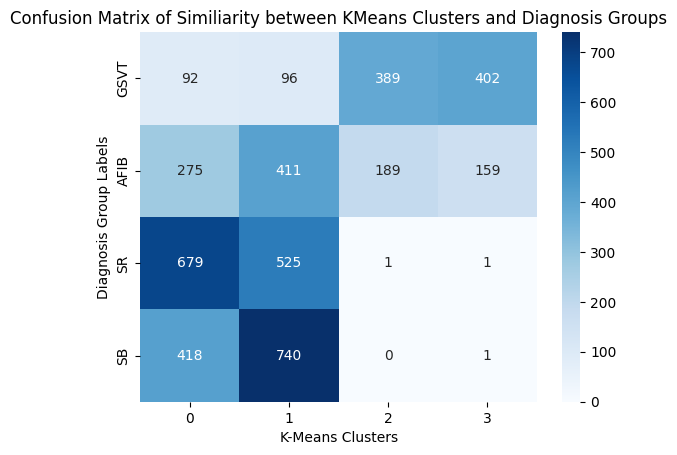

In [13]:
kmeans = KMeans(n_clusters=num_classes, random_state=42)
clusters = kmeans.fit_predict(data_x)

corr_ma = confusion_matrix(data_y, clusters)
sns.heatmap(corr_ma, annot=True, fmt="d", cmap='Blues', yticklabels=label_names)
plt.xlabel('K-Means Clusters')
plt.ylabel('Diagnosis Group Labels')
plt.title('Confusion Matrix of Similiarity between KMeans Clusters and Diagnosis Groups')
plt.show()


In [14]:
# Initialize a dictionary to count patients in each cluster
cluster_patient_count = {i: 0 for i in range(kmeans.n_clusters)}

# Iterate over the assigned clusters and increment the count for each cluster
for cluster in clusters:
    cluster_patient_count[cluster] += 1

# Print the number of patients in each cluster
for cluster, count in cluster_patient_count.items():
    print(f"Cluster {cluster}: {count} patients")

Cluster 0: 1464 patients
Cluster 1: 1772 patients
Cluster 2: 579 patients
Cluster 3: 563 patients


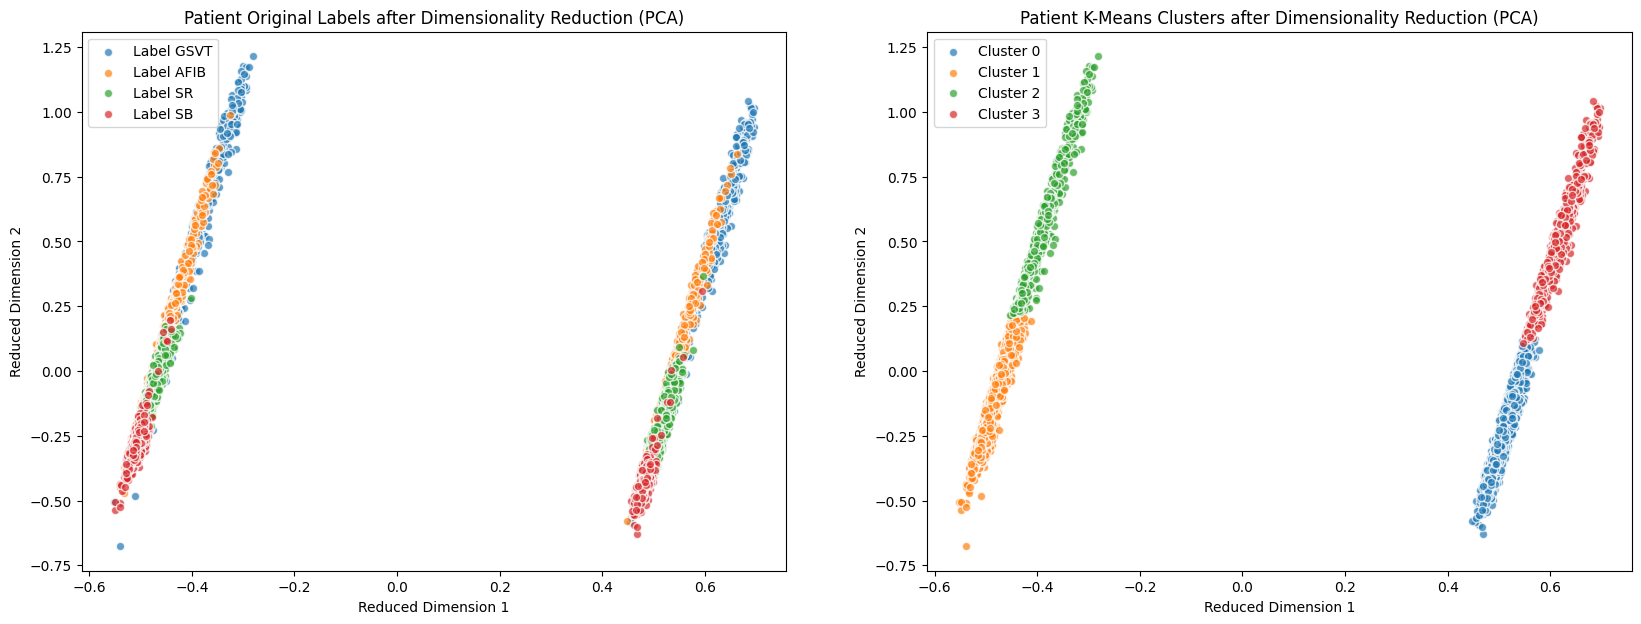

In [15]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_x)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

# First subplot for patient labels after PCA reduction
for i in range(len(set(data_y))):
    cluster_data = reduced_data[data_y == i]
    axs[0].scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Label {label_names[i]}', alpha=0.7, edgecolors='w')

axs[0].set_title('Patient Original Labels after Dimensionality Reduction (PCA)')
axs[0].set_xlabel('Reduced Dimension 1')
axs[0].set_ylabel('Reduced Dimension 2')
axs[0].legend()

# Second subplot for patient clusters after PCA reduction
for i in range(kmeans.n_clusters):
    cluster_data = reduced_data[clusters == i]
    axs[1].scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.7, edgecolors='w')

axs[1].set_title('Patient K-Means Clusters after Dimensionality Reduction (PCA)')
axs[1].set_xlabel('Reduced Dimension 1')
axs[1].set_ylabel('Reduced Dimension 2')
axs[1].legend()

plt.show()

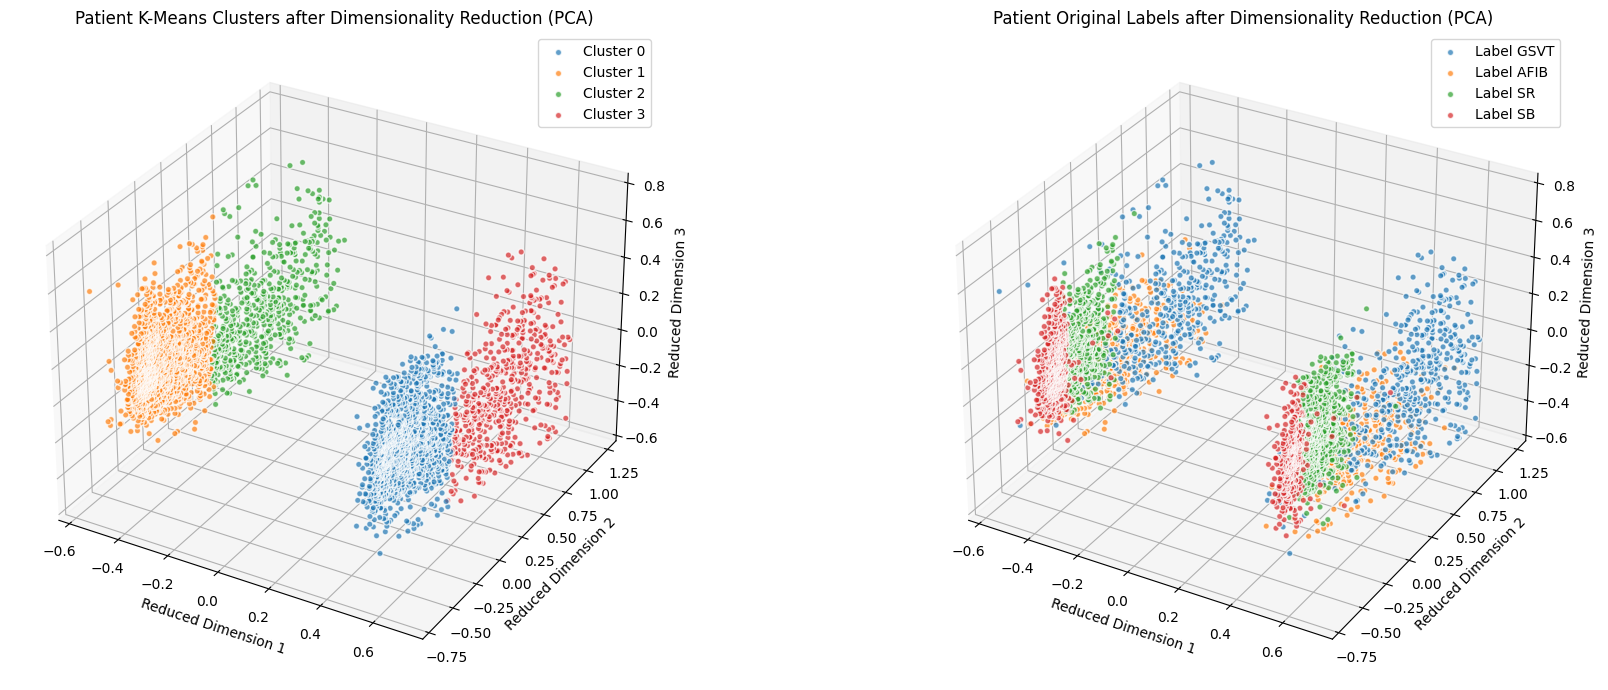

In [16]:
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data_x)

fig = plt.figure(figsize=(20, 7))

# First subplot
ax1 = fig.add_subplot(121, projection='3d')
for i in range(kmeans.n_clusters):
    cluster_data = reduced_data[clusters == i]
    ax1.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {i}', alpha=0.7, edgecolors='w')
ax1.set_title('Patient K-Means Clusters after Dimensionality Reduction (PCA)')
ax1.set_xlabel('Reduced Dimension 1')
ax1.set_ylabel('Reduced Dimension 2')
ax1.set_zlabel('Reduced Dimension 3')
ax1.legend()

# Second subplot
ax2 = fig.add_subplot(122, projection='3d')
for i in range(len(set(data_y))):
    cluster_data = reduced_data[data_y == i]
    ax2.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Label {label_names[i]}', alpha=0.7, edgecolors='w') 
ax2.set_title('Patient Original Labels after Dimensionality Reduction (PCA)')
ax2.set_xlabel('Reduced Dimension 1')
ax2.set_ylabel('Reduced Dimension 2')
ax2.set_zlabel('Reduced Dimension 3')
ax2.legend()

plt.tight_layout()
plt.show()

In [17]:
# Calculate Adjusted Rand Index (ARI)
ari = adjusted_rand_score(data_y, clusters)
print(f"Adjusted Rand Index (ARI): {ari}")

# Calculate Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(data_y, clusters)
print(f"Normalized Mutual Information (NMI): {nmi}")

# Calculate Silhouette Score
silhouette_avg = silhouette_score(data_x, clusters)
print(f"Silhouette Score: {silhouette_avg}")

Adjusted Rand Index (ARI): 0.15412707550646423
Normalized Mutual Information (NMI): 0.24282003848756695
Silhouette Score: 0.46722973644820026


- The ARI and NMI scores suggest that the clustering algorithm has some effectiveness in mirroring the true label structure, but it's not highly accurate. The moderate scores indicate that while there is some alignment with the true labels, the clustering does not perfectly capture the underlying groupings.

- The Silhouette Score indicates that the clustering has identified groups that are somewhat cohesive internally and separated from each other. This suggests that the clustering algorithm has been somewhat successful in identifying meaningful structures within the data, even if those structures don't perfectly align with the true labels.

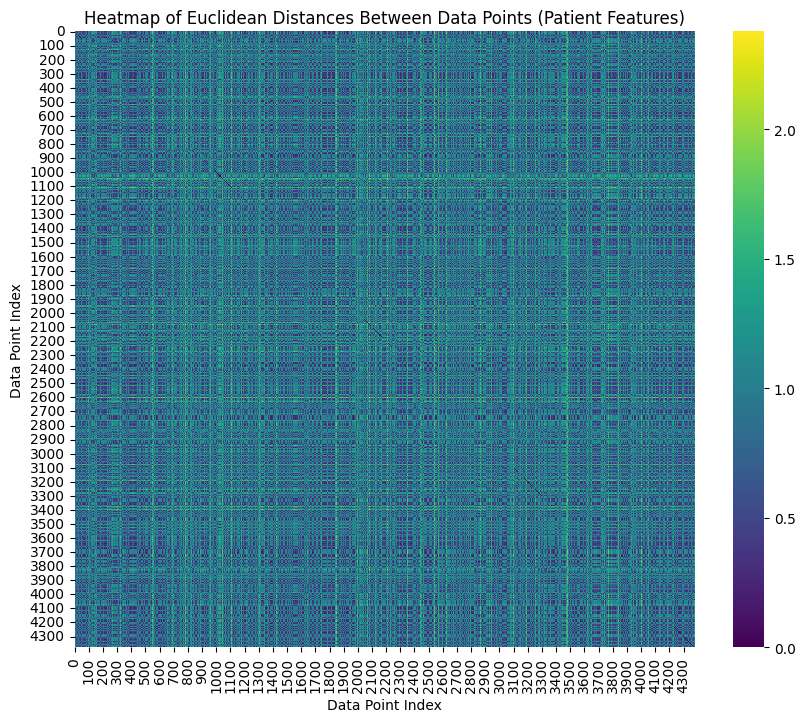

CPU times: total: 9.38 s
Wall time: 10.6 s


In [18]:
%%time
# Compute the distance matrix based on the Euclidean distance between data points
distance_matrix = euclidean_distances(data_x, data_x)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap='viridis')
plt.title('Heatmap of Euclidean Distances Between Data Points (Patient Features)')
plt.xlabel('Data Point Index')
plt.ylabel('Data Point Index')
plt.show()

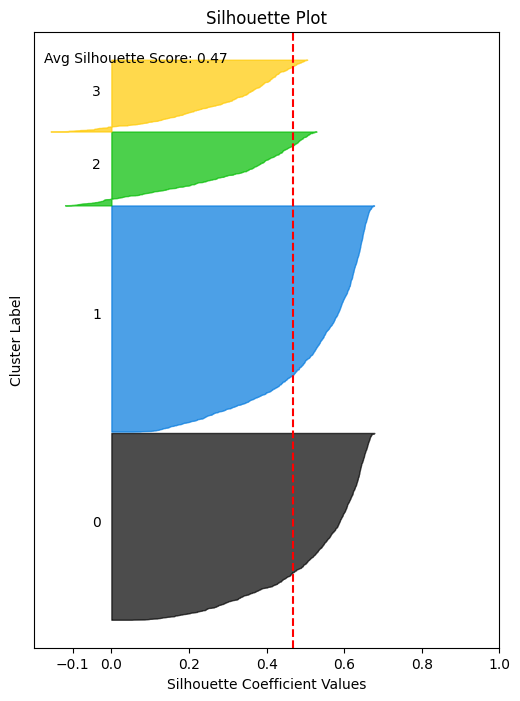

In [19]:
n_clusters = kmeans.n_clusters
# Compute the silhouette scores for each sample
silhouette_vals = silhouette_samples(data_x, clusters)

# Start plotting
fig, ax = plt.subplots(figsize=(6, 8))
y_lower, y_upper = 0, 0
yticks = []

for i, cluster in enumerate(np.unique(clusters)):
    cluster_silhouette_vals = silhouette_vals[clusters == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    
    color = cm.nipy_spectral(float(i) / n_clusters)
    # Ensure the y-axis range matches the length of cluster_silhouette_vals
    y_range = np.arange(y_lower, y_lower + len(cluster_silhouette_vals))
    ax.fill_betweenx(y_range,
                     0, cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(cluster))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

# The vertical line for average silhouette score of all the values
average_score = silhouette_score(data_x, clusters)
ax.axvline(x=average_score, color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis clusters / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title('Silhouette Plot')
plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster Label')

# Add the silhouette score to the plot
plt.text(0.02, 0.95, f'Avg Silhouette Score: {average_score:.2f}', transform=ax.transAxes)

plt.show()

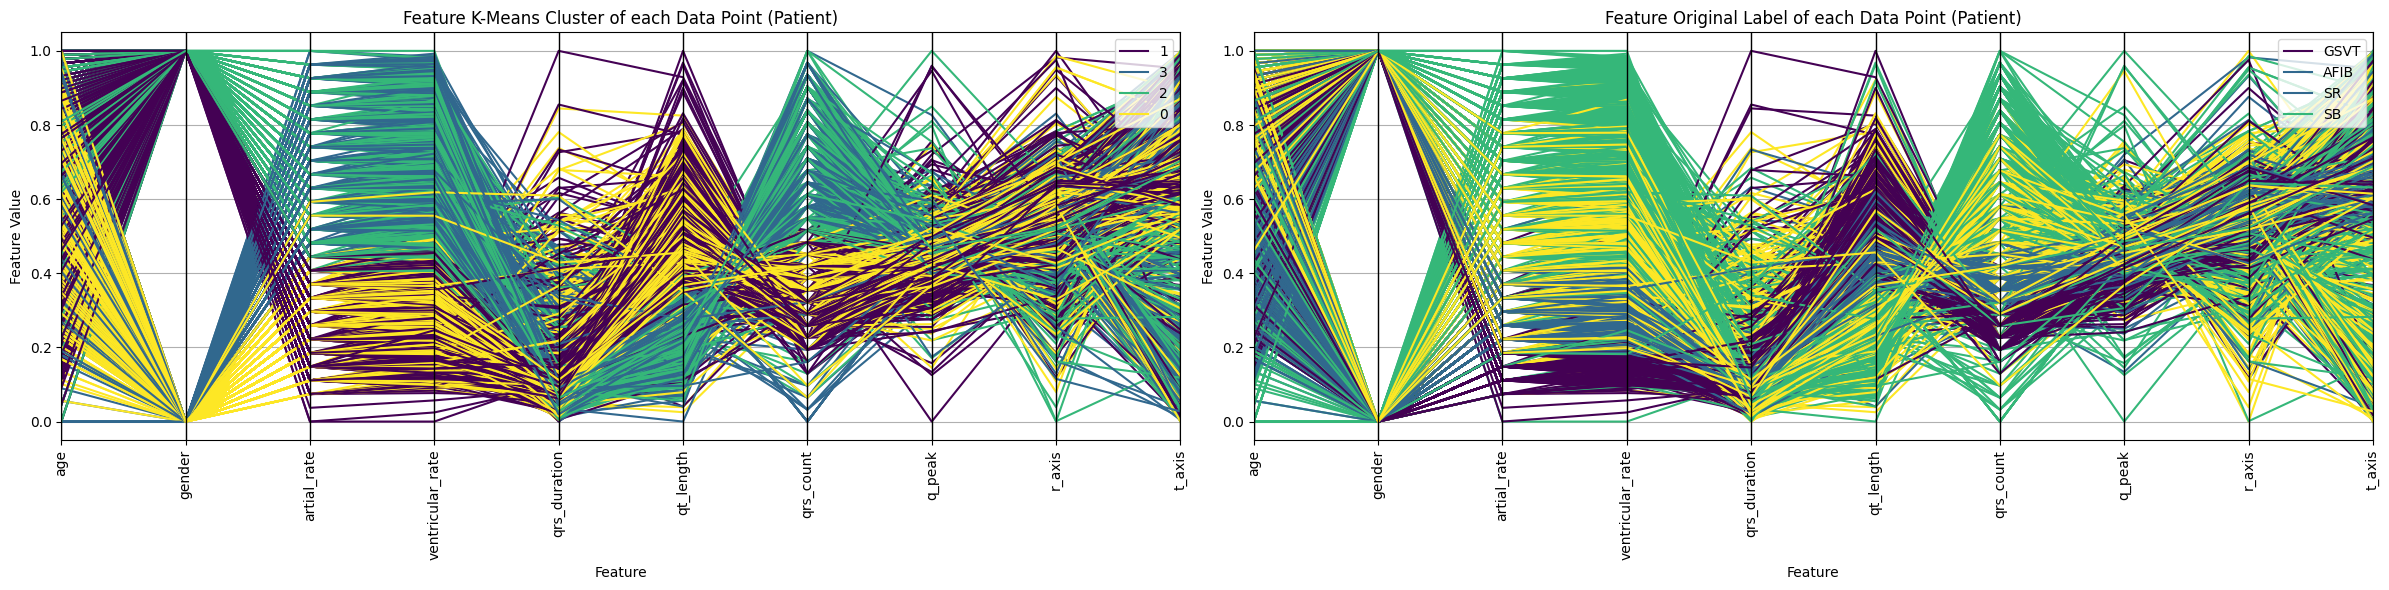

In [20]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

# First subplot for clusters
plot_data_clusters = pd.DataFrame(data_x.copy())
plot_data_clusters['Cluster'] = clusters
new_columns_clusters = plot_data_clusters.columns.tolist()
new_columns_clusters[0:10] = feature_names
plot_data_clusters.columns = new_columns_clusters
parallel_coordinates(plot_data_clusters, 'Cluster', colormap='viridis', ax=axes[0])
axes[0].set_title('Feature K-Means Cluster of each Data Point (Patient)')
axes[0].set_xlabel('Feature')
axes[0].set_ylabel('Feature Value')
axes[0].tick_params(axis='x', rotation=90)

# Second subplot for labels
plot_data_labels = pd.DataFrame(data_x.copy())
label_data = data_y.reset_index(drop=True)
plot_data_labels['Cluster'] = label_data

new_columns_labels = plot_data_labels.columns.tolist()
new_columns_labels[0:10] = feature_names
plot_data_labels.columns = new_columns_labels
parallel_coordinates(plot_data_labels, 'Cluster', colormap='viridis', ax=axes[1])
axes[1].set_title('Feature Original Label of each Data Point (Patient)')
axes[1].set_xlabel('Feature')
axes[1].set_ylabel('Feature Value')
axes[1].tick_params(axis='x', rotation=90)
# set the legend
axes[1].legend(loc='upper right', labels=label_names)

plt.tight_layout()
plt.show()